# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [10]:
%pip install tf-nightly --upgrade
%pip install scikit-learn --upgrade

%pip install scikit-image --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn import metrics as me

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tf-metal-nightly (from versions: none)
ERROR: No matching distribution found for tf-metal-nightly
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the `mnist` dataset and normalize in the range [0, 1]

In [5]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

11490434/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [6]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [7]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

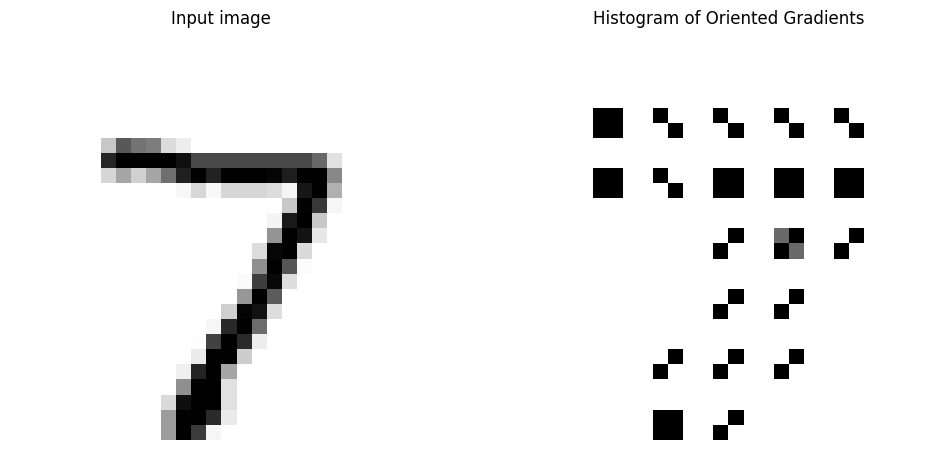

In [8]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [9]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [16]:
model = Sequential()
print(hog_size)
model.add(Dense(200, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

392
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               78600     
                                                                 
 dense_3 (Dense)             (None, 10)                2010      
                                                                 
Total params: 80,610
Trainable params: 80,610
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [13]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 1s 1ms/step - loss: 0.2360 - accuracy: 0.9410 - val_loss: 0.0864 - val_accuracy: 0.9737
Epoch 2/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0913 - accuracy: 0.9711 - val_loss: 0.0719 - val_accuracy: 0.9775
Epoch 3/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.9757 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 4/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0656 - accuracy: 0.9792 - val_loss: 0.0639 - val_accuracy: 0.9788
Epoch 5/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.0648 - val_accuracy: 0.9787
Epoch 6/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0504 - accuracy: 0.9840 - val_loss: 0.0680 - val_accuracy: 0.9785
Epoch 7/10
422/422 [==============================] - 0s 1ms/step - loss: 0.0446 - accuracy: 0.9860 - val_loss: 0.0610 - val_accuracy: 0.9812
Epoch 

Show the performance of the model

Test score: 0.06456153839826584
Test accuracy: 0.979200005531311


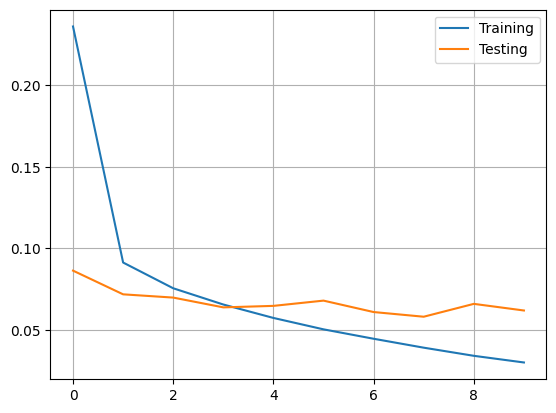

In [14]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [15]:
pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

313/313 [==============================] - 0s 412us/step


array([[ 966,    0,    3,    0,    0,    2,    6,    1,    1,    1],
       [   3, 1118,    1,    4,    0,    1,    4,    0,    4,    0],
       [   1,    1, 1017,    0,    2,    0,    3,    5,    3,    0],
       [   0,    0,    1,  995,    0,    8,    1,    2,    3,    0],
       [   1,    2,    4,    1,  960,    0,    2,    1,    3,    8],
       [   2,    1,    0,   14,    0,  870,    4,    0,    1,    0],
       [   2,    2,    1,    0,    2,    2,  949,    0,    0,    0],
       [   0,    2,    8,    4,    5,    0,    0,  993,    5,   11],
       [   3,    0,    2,   10,    0,    1,    1,    4,  946,    7],
       [   0,    3,    1,    8,    5,    5,    0,    5,    4,  978]])